In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import hypernetx as hnx
from scipy.stats import pearsonr
from scipy.stats import linregress
from tqdm import tqdm
import glob
import scanpy as sc 

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("../utilities/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import matrix as matrix
import centrality as central
import curvature as curv

# Sensitivity to node weights

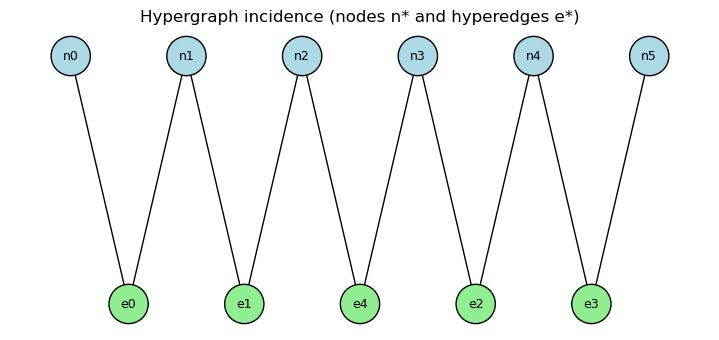

In [2]:
# ---- 1) Tiny hypergraph: 6 nodes, 5 hyperedges ----
# Edges (as node index lists, 0-based):
# community A: e0={0,1}, e1={1,2}; community B: e2={3,4}, e3={4,5}; bridge e4={2,3}
edges = [
    [0, 1],   # e0
    [1, 2],   # e1
    [3, 4],   # e2
    [4, 5],   # e3
    [2, 3],   # e4 (bridge)
]

# Convert to bipartite graph: nodes vs edges
B = nx.Graph()
for j, S in enumerate(edges):
    e_name = f"e{j}"
    for i in S:
        B.add_edge(f"n{i}", e_name)

# Layout
pos = {}
# Node positions (arranged in two communities with bridge)
pos.update({f"n{i}": (i, 0) for i in range(6)})
pos.update({f"e{j}": (sum(edges[j])/len(edges[j]), -1) for j in range(len(edges))})

# Plot
plt.figure(figsize=(7,3))
nx.draw(
    B, pos, with_labels=True,
    node_color=["lightblue" if n.startswith("n") else "lightgreen" for n in B.nodes()],
    node_size=800, edgecolors="black", font_size=9
)
plt.title("Hypergraph incidence (nodes n* and hyperedges e*)")
plt.show()

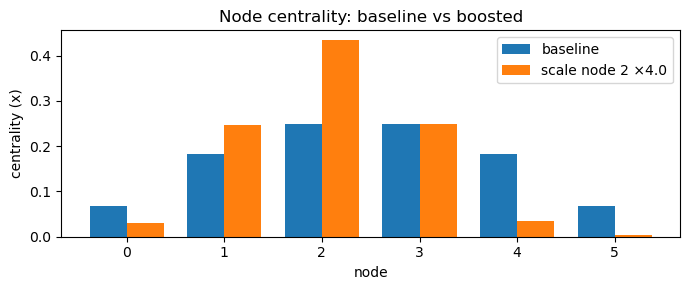

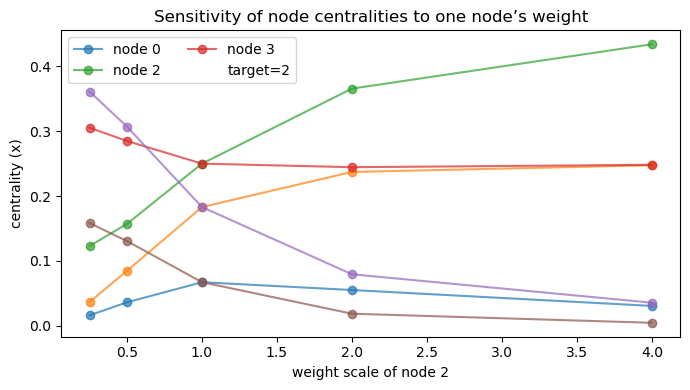

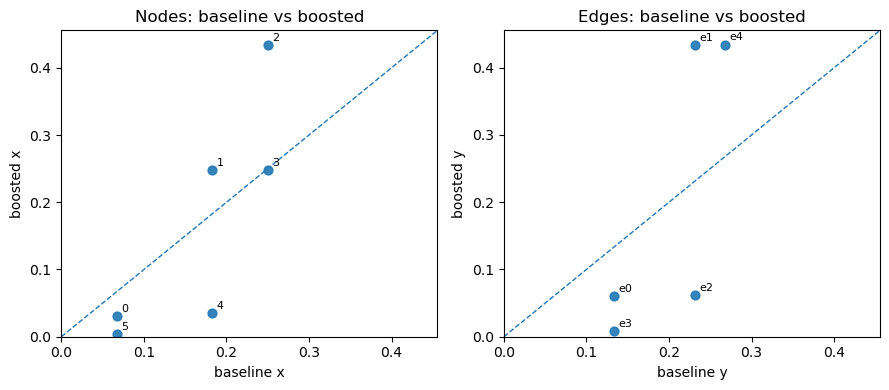

In [3]:
n = 6
m = len(edges)
rows, cols, vals = [], [], []
for j, S in enumerate(edges):
    for i in S:
        rows.append(i); cols.append(j); vals.append(1.0)
B = sp.csr_matrix((vals, (rows, cols)), shape=(n, m))

# ---- 2) Baseline (uniform weights) ----
x_base, y_base = central.hevc(B, function='linear', node_weights=np.ones((n,1)), edge_weights=np.ones((m,1)))

# ---- 3) Sweep a single node’s weight ----
target = 2         # pick node 2 (near the bridge)
scales = np.array([0.25, 0.5, 1.0, 2.0, 4.0])
X_sweep = []       # node centralities for each scale
Y_sweep = []       # edge centralities for each scale

for s in scales:
    nw = np.ones((n,1))
    nw[target,0] = s
    x_s, y_s = central.hevc(B, function='linear', node_weights=nw, edge_weights=np.ones((m,1)))
    X_sweep.append(x_s)
    Y_sweep.append(y_s)

X_sweep = np.vstack(X_sweep).reshape(len(scales), n)   # shape: (len(scales), n)
Y_sweep = np.vstack(Y_sweep).reshape(len(scales), m)   # shape: (len(scales), m)

# ---- 4A) Bars: baseline vs boosted (use the largest scale) ----
plt.figure(figsize=(7,3))
idx = np.arange(n)
width = 0.38
plt.bar(idx - width/2, x_base, width, label='baseline')
plt.bar(idx + width/2, X_sweep[-1], width, label=f'scale node {target} ×{scales[-1]}')
plt.xlabel('node')
plt.ylabel('centrality (x)')
plt.xticks(idx, [f'{i}' for i in range(n)])
plt.legend()
plt.title('Node centrality: baseline vs boosted')
plt.tight_layout()
plt.show()

# ---- 4B) Sensitivity: node centrality vs weight scale ----
plt.figure(figsize=(7,4))
for i in range(n):
    plt.plot(scales, X_sweep[:, i], marker='o', label=f'node {i}' if i in [target,0,3] else None, alpha=0.7)
# light legend: show only a few labels to stay uncluttered
plt.plot([], [], ' ', label=f'target={target}')
plt.xlabel(f'weight scale of node {target}')
plt.ylabel('centrality (x)')
# plt.xscale('log')  # log scale better shows trend
plt.title('Sensitivity of node centralities to one node’s weight')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

# ---- 4C) Scatter: baseline vs boosted (nodes and edges) ----
fig, axes = plt.subplots(1, 2, figsize=(9,4))

# Nodes
ax = axes[0]
ax.scatter(x_base, X_sweep[-1], s=40, alpha=0.9)
lim = (0, max(ax.get_xlim()[1], ax.get_ylim()[1]))
ax.plot(lim, lim, ls='--', lw=1)
ax.set_xlim(lim); ax.set_ylim(lim)
ax.set_xlabel('baseline x'); ax.set_ylabel('boosted x')
ax.set_title('Nodes: baseline vs boosted')
for i in range(n):
    ax.annotate(str(i), (x_base[i], X_sweep[-1, i]), fontsize=8, xytext=(3,3), textcoords='offset points')

# Edges
ax = axes[1]
ax.scatter(y_base, Y_sweep[-1], s=40, alpha=0.9)
lim = (0, max(ax.get_xlim()[1], ax.get_ylim()[1]))
ax.plot(lim, lim, ls='--', lw=1)
ax.set_xlim(lim); ax.set_ylim(lim)
ax.set_xlabel('baseline y'); ax.set_ylabel('boosted y')
ax.set_title('Edges: baseline vs boosted')
for j in range(m):
    ax.annotate(f"e{j}", (y_base[j], Y_sweep[-1, j]), fontsize=8, xytext=(3,3), textcoords='offset points')

plt.tight_layout()
plt.show()


# some HEVC examples

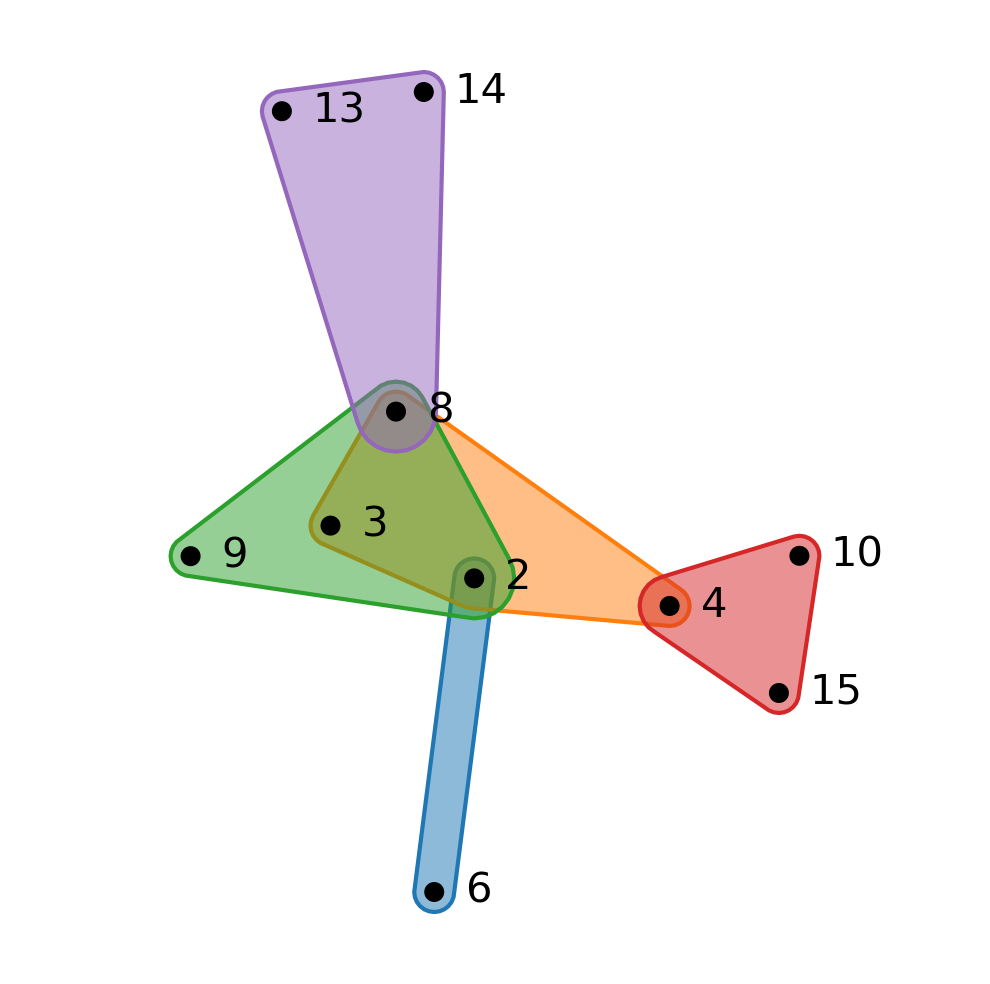

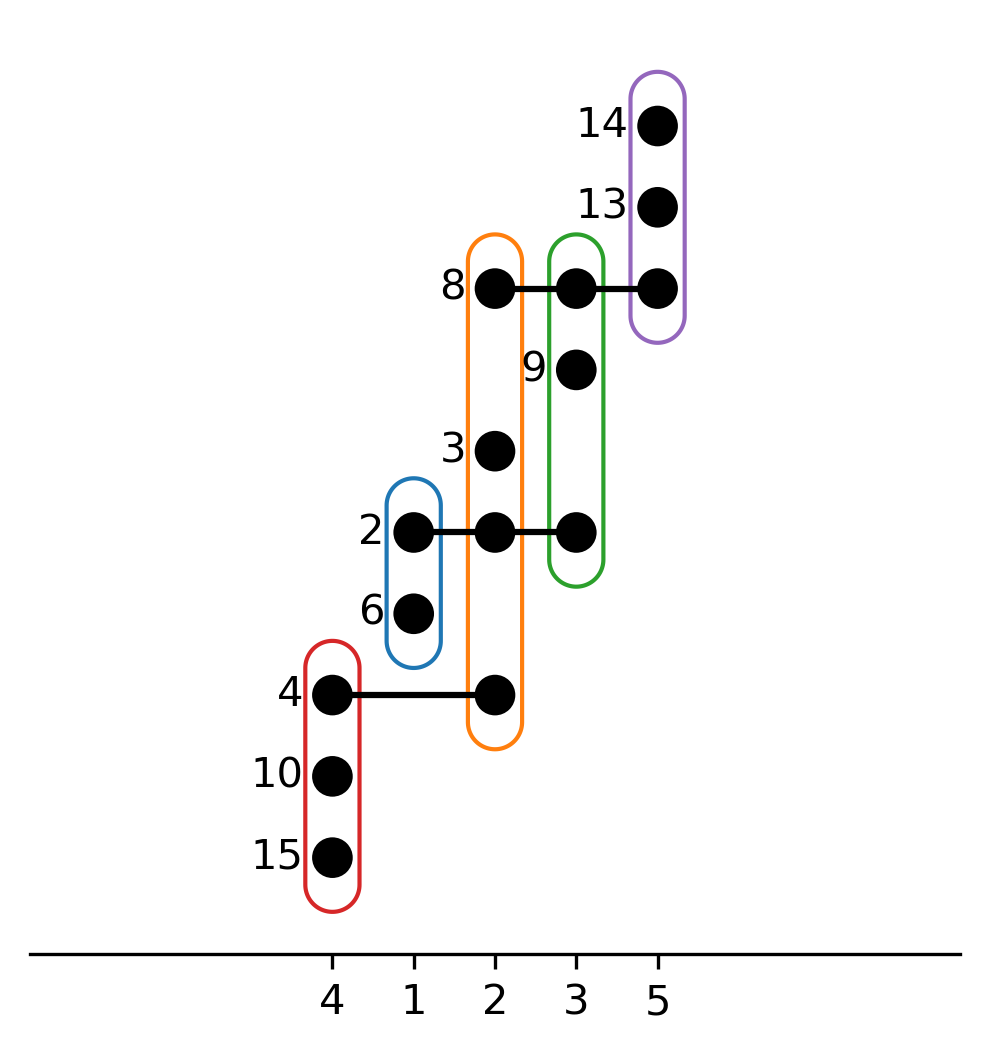

In [4]:
hyperedges = {
    1: {2, 6},        # cluster around node 1–2–6–7
    2: {2, 3, 4, 8},        # core connection 2–3–4–8
    3: {2, 9, 8},      # branch from 2 to 9–11–12
    4: {4, 10, 15},      # chain from 3 to 15
    5: {8, 13, 14},         # branch from 8 to 14
}  

# Create the HyperNetX hypergraph
H = hnx.Hypergraph(hyperedges)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

pos = hnx.draw(
    H, fill_edges=True,
    layout=nx.spring_layout,
    node_label_alpha=0.0, 
    edge_label_alpha=0.0,
    with_edge_labels=False,
    return_pos=True,
)

plt.gcf().set_facecolor('none')
plt.show()

hnx.draw_incidence_upset(H)
plt.show()

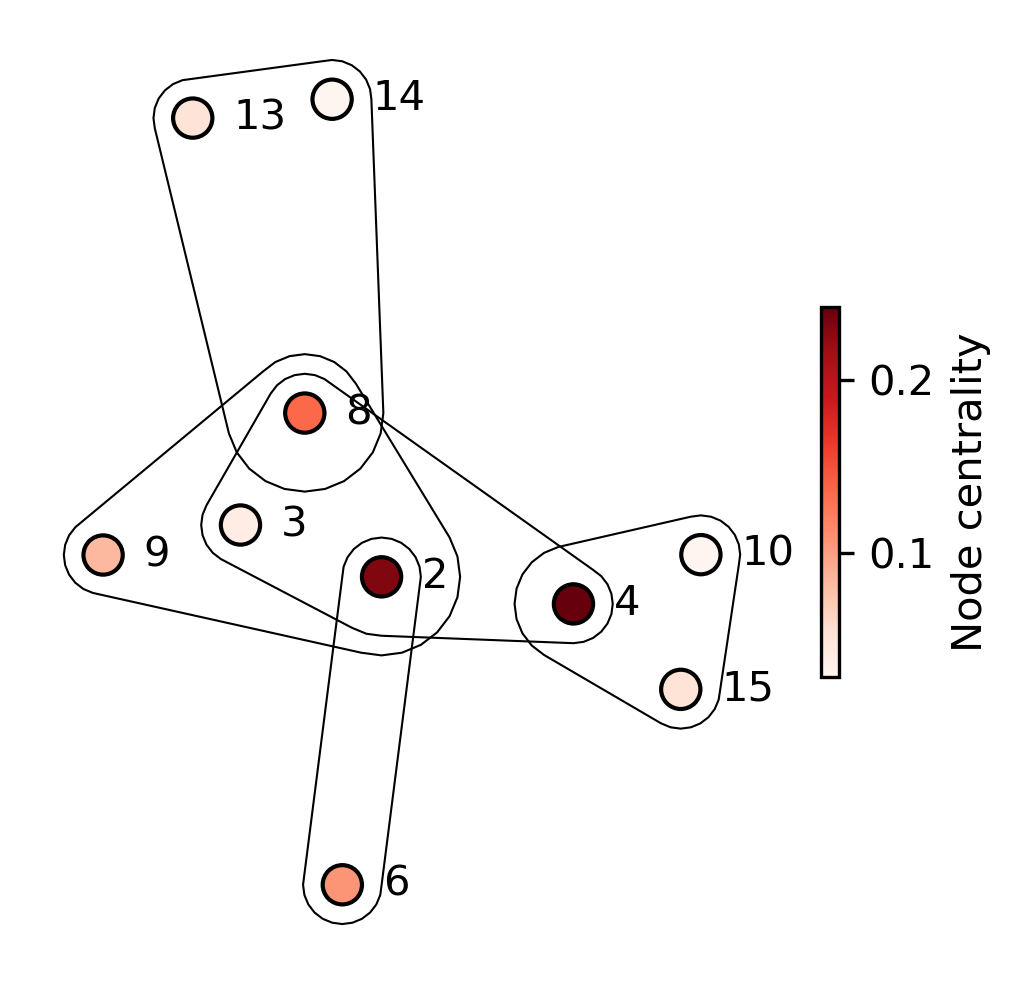

In [5]:
node_ev, _ = central.hevc(
    H.incidence_dataframe(), 
    function='linear',
)

# Make a mapping: node -> centrality
node_ev_dict = {n: val for n, val in zip(H.nodes, node_ev)}

# Normalize values to [0,1] for colormap
norm = plt.Normalize(vmin=min(node_ev), vmax=max(node_ev))
cmap = plt.cm.Reds

# Assign color per node
node_colors = {n: cmap(norm(node_ev_dict[n])) for n in H.nodes}
node_sizes = [10 for n in H.nodes]

# Draw hypergraph
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (4, 4)

hnx.draw(
    H, pos=pos,
    node_label_alpha=0.0,
    edge_label_alpha=0.0,
    with_edge_labels=False,
    edges_kwargs={'edgecolors' : 'k', 'linewidth' : 0.5,},
    nodes_kwargs={'color' : node_colors, 'edgecolor' : 'k'},
    node_radius = 2,
)

ax = plt.gca()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.4, label="Node centrality")
plt.gcf().set_facecolor('none')
plt.show()

CPU times: user 3.49 s, sys: 30.5 ms, total: 3.52 s
Wall time: 3.52 s


Text(0.5, 1.0, 'Linear HEVC w/ Random Node Weights')

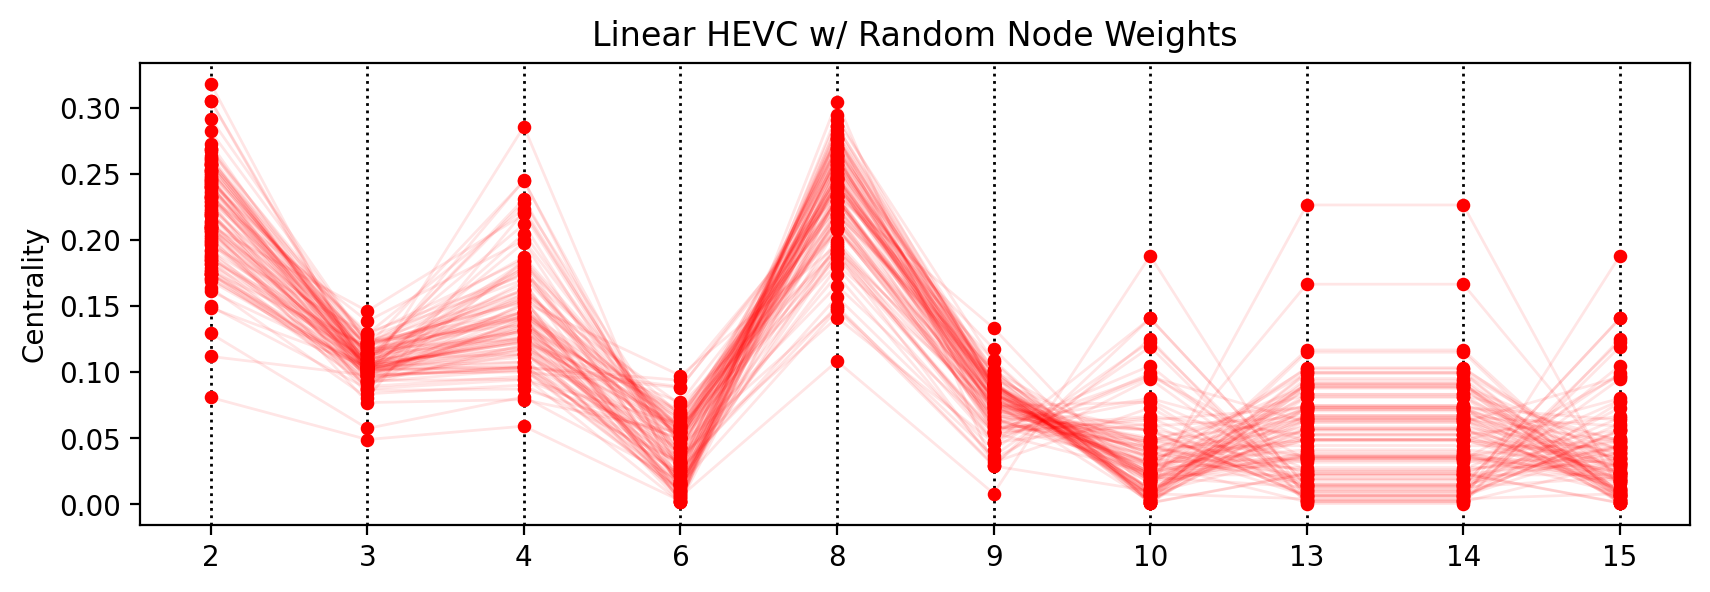

In [6]:
%%time
n_iter = 100
B = H.incidence_dataframe()
n_nodes = len(B)

results = []

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

# Iterate, randomly selecting distribution each time
for k in range(n_iter):
    weights = np.random.rand(len(B)) 
    
    # run centrality
    node_ev, _ = central.hevc(
        B, 
        function='linear',
        node_weights=weights,
    )

   # Line only (faint)
    sns.lineplot(
        x=range(len(node_ev)),
        y=node_ev,
        lw=1,
        c='r',
        alpha=0.1,   # <-- line alpha
        zorder=1,
        marker=None
    )
    
    # Markers only (opaque)
    plt.scatter(
        range(len(node_ev)),
        node_ev,
        c='r',
        s=15,
        alpha=1.0,   # <-- marker alpha
        zorder=2
    )
    

plt.xticks(range(n_nodes), B.index)
plt.grid(axis='x', lw=1, c='k', zorder=0, ls=":")
plt.ylabel("Centrality")
plt.title("Node")

plt.title("Linear HEVC w/ Random Node Weights")

CPU times: user 1.98 s, sys: 13.7 ms, total: 1.99 s
Wall time: 2 s


Text(0.5, 1.0, 'Log-Exp HEVC w/ Random Node Weights')

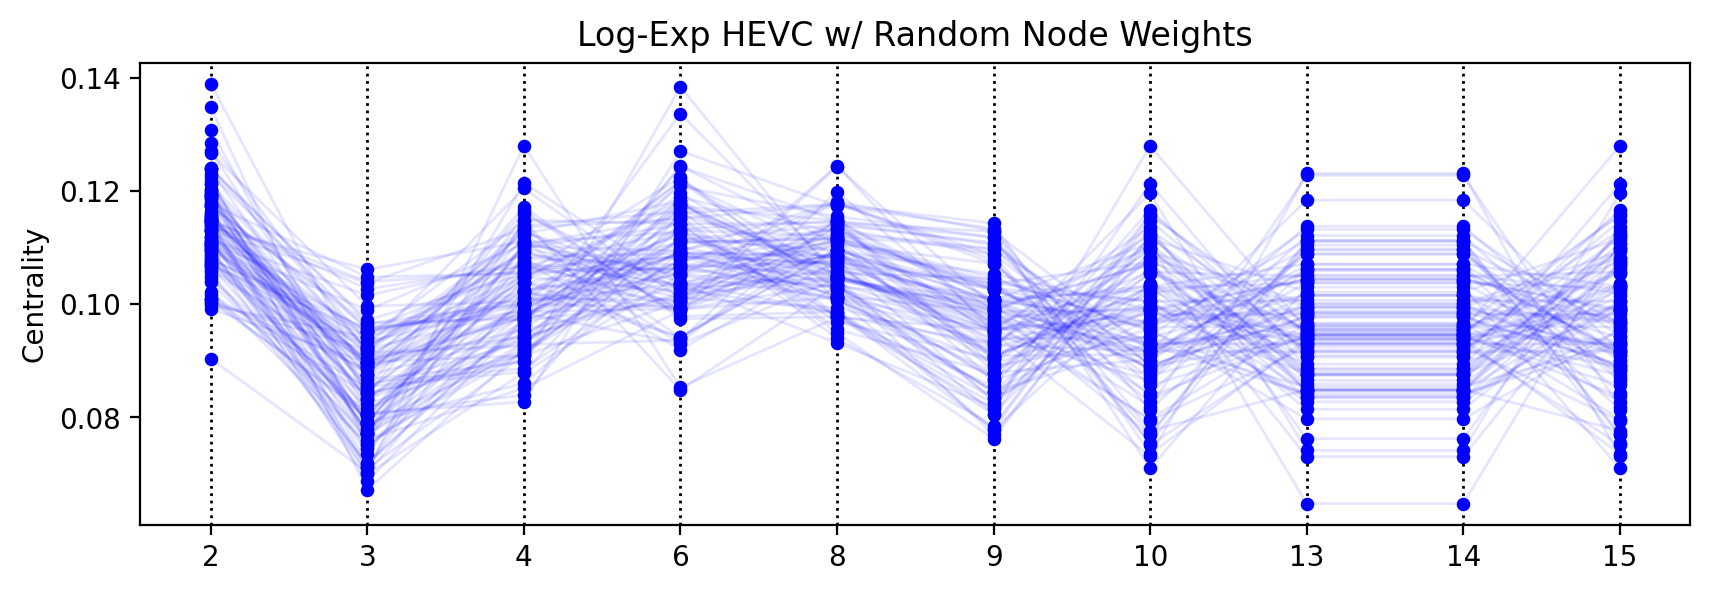

In [7]:
%%time
n_iter = 100
B = H.incidence_dataframe()
n_nodes = len(B)

results = []

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

# Iterate, randomly selecting distribution each time
for k in range(n_iter):
    weights = np.random.rand(len(B)) 
    
    # run centrality
    node_ev, _ = central.hevc(
        B, 
        function='log-exp',
        node_weights=weights,
    )

   # Line only (faint)
    sns.lineplot(
        x=range(len(node_ev)),
        y=node_ev,
        lw=1,
        c='b',
        alpha=0.1,   # <-- line alpha
        zorder=1,
        marker=None
    )
    
    # Markers only (opaque)
    plt.scatter(
        range(len(node_ev)),
        node_ev,
        c='b',
        s=15,
        alpha=1.0,   # <-- marker alpha
        zorder=2
    )
    

plt.xticks(range(n_nodes), B.index)
plt.grid(axis='x', lw=1, c='k', zorder=0, ls=":")
plt.ylabel("Centrality")
plt.title("Node")

plt.title("Log-Exp HEVC w/ Random Node Weights")

CPU times: user 1.92 s, sys: 10.8 ms, total: 1.93 s
Wall time: 1.93 s


Text(0.5, 1.0, 'Max HEVC w/ Random Node Weights')

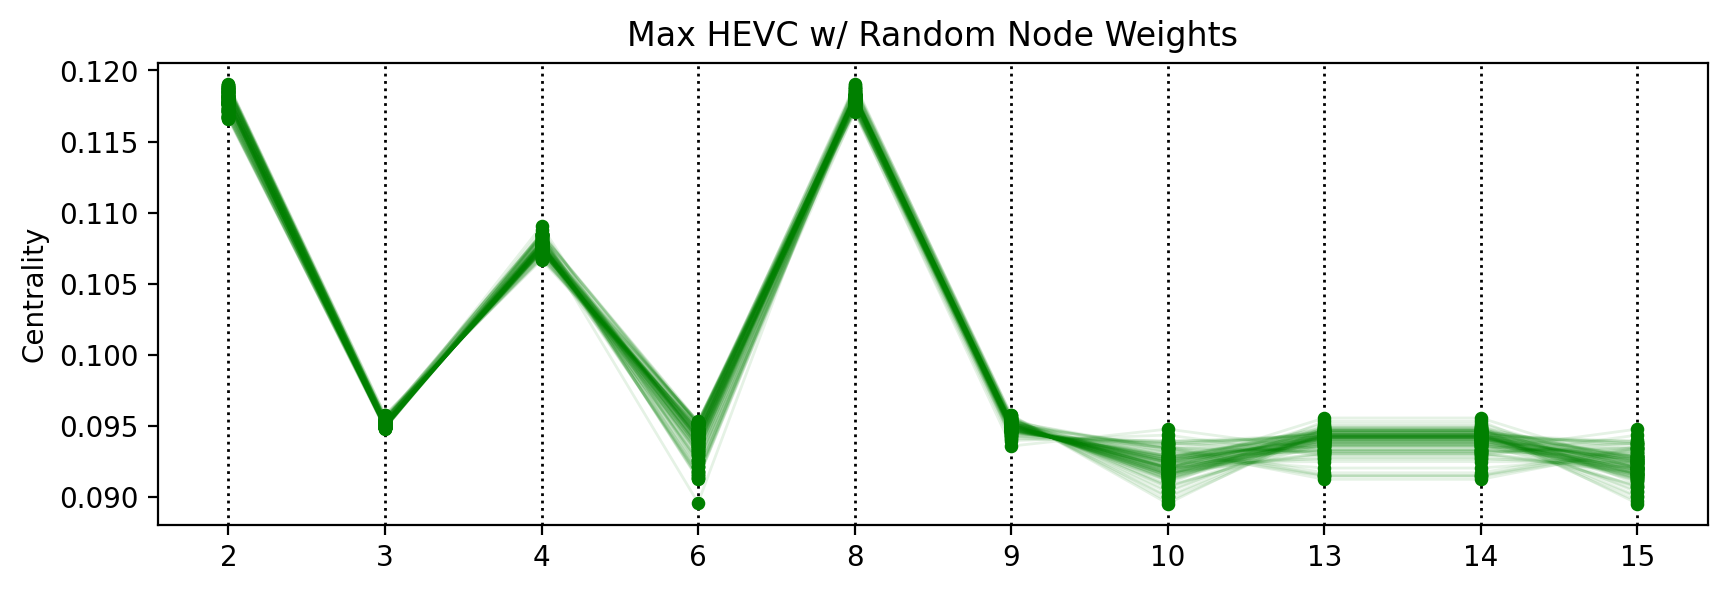

In [9]:
%%time
n_iter = 100
B = H.incidence_dataframe()
n_nodes = len(B)

results = []

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

# Iterate, randomly selecting distribution each time
for k in range(n_iter):
    weights = np.random.rand(len(B)) 
    
    # run centrality
    node_ev, _ = central.hevc(
        B, 
        function='max',
        node_weights=weights,
    )

   # Line only (faint)
    sns.lineplot(
        x=range(len(node_ev)),
        y=node_ev,
        lw=1,
        c='g',
        alpha=0.1,   # <-- line alpha
        zorder=1,
        marker=None
    )
    
    # Markers only (opaque)
    plt.scatter(
        range(len(node_ev)),
        node_ev,
        c='g',
        s=15,
        alpha=1.0,   # <-- marker alpha
        zorder=2
    )
    

plt.xticks(range(n_nodes), B.index)
plt.grid(axis='x', lw=1, c='k', zorder=0, ls=":")
plt.ylabel("Centrality")
plt.title("Node")

plt.title("Max HEVC w/ Random Node Weights")

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)